# SWSN - EaT-PIM with simplified ingredients and ingredient metadata

Bartosz Stachowiak 148259<br>
Andrzej Kajdasz 148273

## 1. Introduction
After reading [EaT-PIM: Substituting Entities in Procedural Instructions using Flow Graphs and Embeddings (Sola S. Shirai, HyeongSik Kim)](https://dspace.rpi.edu/bitstream/handle/20.500.13015/6364/ISWC_EaT_PIM.pdf?sequence=1&isAllowed=y&fbclid=IwAR3RaVCT2_kb0T5NmVNs2ulIxjWkbDBu8T9wfUrIk7pSrjLcRQEeA6BqVkg) we noticed a room for improvement in the appraoch. We hypothesize that we could improve the results by incorporating other information besides the ingredients themselves to improve the quality of the suggestions.
<br><br>
The first and most important task for us is to incorporate ingredient metadata in substitute prediction. The proposed model utilizes only the contextual information about the ingredient from recipes, which is not always accurate (completely different ingredients might be prepared in similar ways but do not taste alike). To improve the quality of the prediction, we could incorporate the metadata about individual ingredients (e.g. taste, type) and make a prediction as a combination of the two sources. The plan for us is to describe the metadata in form of a feature matrix (one-hot encoded), combine similarity metric between the missing ingredient and its alternatives, combine the metric with paper's original approach using weights, find most appropriate replacements
<br><br>
The second proposition equally important is to simplify the ingredients to get more informative predictions. The authors seem to have used very granular distinction between individual ingredients, which sometimes give very unhelpful substitution propositions (e.g. pork => boneless pork). Simplifying the distinction and grouping very similar ingredients could help with more insightful predictions. To achieve such results we will prune any modifiers from existing ingredients (e.g. boneless pork), aggregate ingredients to their simplest form.

We strongly believe that with these two changes, we will be able to improve upon the initial solution.

## 2. EDA

### 2.1 Original Dataset

Raw data are taken from [kaggle - Food.com Recipes and Interactions dataset](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions).

This dataset was created by scraping over 230k recipies from [Food.com](food.com).

In [1]:
import itertools
import collections
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/RAW_recipes.csv')
df.set_index('id', inplace=True)
df.head()

,name,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
id,,,,,,,,,,,
137739,arriba baked winter squash mexican style,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


#### 2.1.1. Column Description

The dataset consists of recipies, each described by the following:
- **name** - name of the recipe, string, lowercase 
- **id** - id of the recipe, int
- **minutes** - time needed to prepare the recipe in minutes, int
- **contributor_id** - id of the contributor, int
- **submitted** - date of submission, string, format: YYYY-MM-DD
- **tags** - tags of the recipe, list of lowercase strings
- **nutrition** - nutrition information, list of 7 floats:
  - **calories (#)**
  - **total fat (PDV)**
  - **sugar (PDV)**
  - **sodium (PDV)**
  - **protein (PDV)**
  - **saturated fat (PDV)**
  - **carbohydrates (PDV)**
- **n_steps** - number of steps in the recipe, int
- **steps** - steps of the recipe, list of strings
- **description** - description of the recipe, string
- **ingredients** - ingredients of the recipe, list of strings
- **n_ingredients** - number of ingredients in the recipe, int

The authors of the paper have used only the **ingredients** and **steps** columns, which we will also use in our approach.

In [3]:
def parse_string_list(string_list: str) -> list[str]:
    return [token[1:-1] for token in string_list[1:-1].replace(" , ", "; ").split(", ")]

ingredients = df.ingredients.apply(parse_string_list).tolist()
steps = df.steps.apply(parse_string_list).tolist()

#### 2.1.2. Ingredients

On average, each recipe has 9 ingredients.

In [4]:
df.n_ingredients.describe()

count    231637.000000
mean          9.051153
std           3.734796
min           1.000000
25%           6.000000
50%           9.000000
75%          11.000000
max          43.000000
Name: n_ingredients, dtype: float64

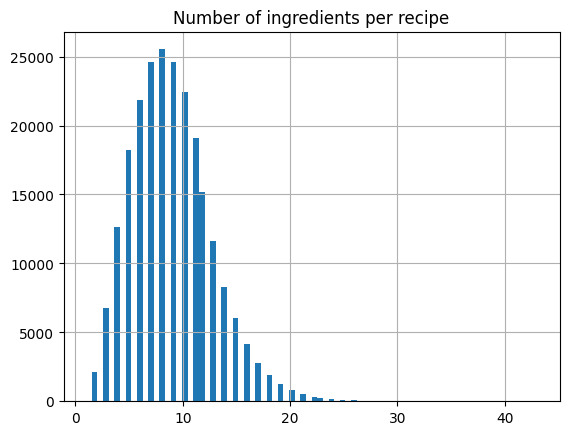

In [5]:
df.n_ingredients.hist(bins=80)
plt.title("Number of ingredients per recipe")
plt.show()

In [6]:
ingredient_counts = collections.Counter(itertools.chain.from_iterable(ingredients))

print("Total number of ingredients:", len(ingredient_counts))

Total number of ingredients: 14917


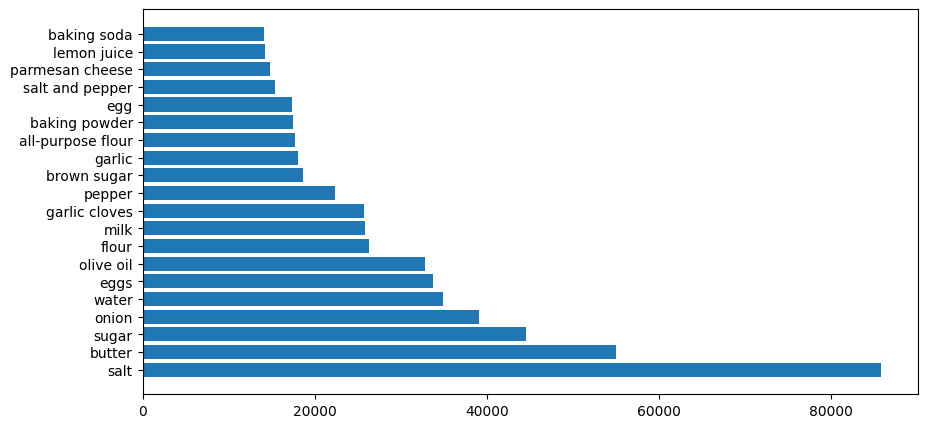

In [65]:
most_common_ingredients = ingredient_counts.most_common(20)
plt.figure(figsize=(10, 5))
plt.barh([ingredient for ingredient, _ in most_common_ingredients], [count for _, count in most_common_ingredients])
plt.show()

In [8]:
counts_arr = np.array(tuple(ingredient_counts.values()))
used_only_once_count = (counts_arr < 2).sum()
used_less_than_5_count = (counts_arr < 5).sum()

print(f"{used_only_once_count / len(ingredient_counts) * 100:.2f}% of ingredients are used only in one recipe")
print(f"{used_less_than_5_count / len(ingredient_counts) * 100:.2f}% of ingredients are used in less than 5 recipes")

23.76% of ingredients are used only in one recipe
46.42% of ingredients are used in less than 5 recipes


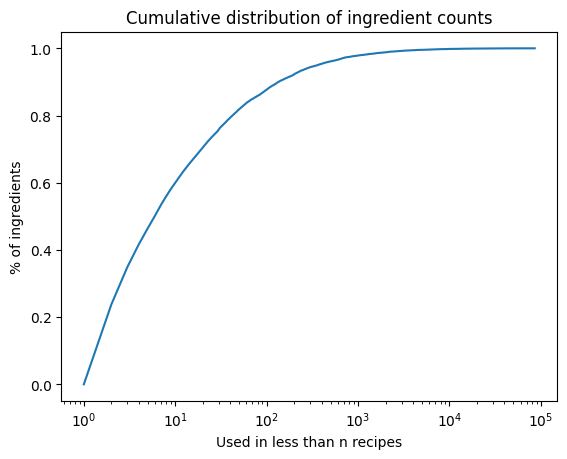

In [68]:
ing_x = [i for i in range(1, counts_arr.max() + 1)]
ing_y = [(counts_arr < i).sum() / counts_arr.shape[0] for i in ing_x]
plt.plot(ing_x, ing_y)
plt.xscale('log')
plt.title("Cumulative distribution of ingredient counts")
plt.xlabel("Used in less than n recipes")
plt.ylabel("% of ingredients")
plt.show()

Many ingredients are very sparsly used, which is a problem for our approach. They are unlikely to be useful in the prediction, but some of them might be grouped to some more general ingredients. Some examples of such ingredients are:

In [10]:
for ing in list(ingredient_counts.keys())[-10:]:
    print(ing)

low-fat low-sodium condensed cream of tomato soup
thousand island sandwich spread
pesto garlic tortillas
roasted red pepper pesto
seasoned rice vinegar with roasted garlic
apricot jell-o
rosarita premium whole black beans
hunt's fire roasted diced tomatoes
skinless halibut fillet
nepitella


#### 2.1.3. Steps

On average, each recipe has 10 steps.

In [11]:
df.n_steps.describe()

count    231637.000000
mean          9.765499
std           5.995128
min           0.000000
25%           6.000000
50%           9.000000
75%          12.000000
max         145.000000
Name: n_steps, dtype: float64

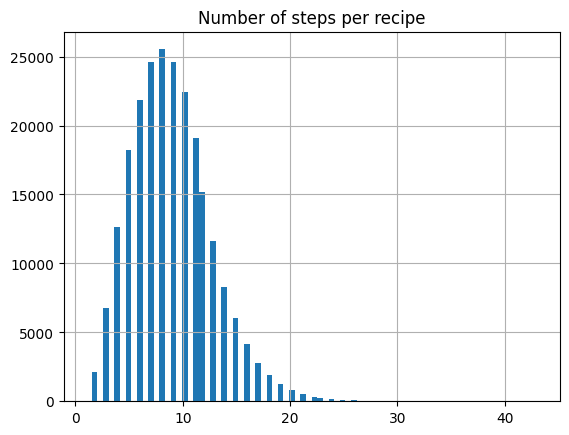

In [12]:
df.n_ingredients.hist(bins=80)
plt.title("Number of steps per recipe")
plt.show()

Example of a recipe:

In [13]:
for i, step in enumerate(steps[0]):
    print(f"{i+1:>4}. {step}")

   1. make a choice and proceed with recipe
   2. depending on size of squash; cut into half or fourths
   3. remove seeds
   4. for spicy squash; drizzle olive oil or melted butter over each cut squash piece
   5. season with mexican seasoning mix ii
   6. for sweet squash; drizzle melted honey; butter; grated piloncillo over each cut squash piece
   7. season with sweet mexican spice mix
   8. bake at 350 degrees; again depending on size; for 40 minutes up to an hour; until a fork can easily pierce the skin
   9. be careful not to burn the squash especially if you opt to use sugar or butter
  10. if you feel more comfortable; cover the squash with aluminum foil the first half hour; give or take; of baking
  11. if desired; season with salt


### 2.2. Taste Dataset

As we will want to include ingredients metadata in the component substitutes prediction, we needed a dataset that will facilitate this information.

For this reason we analyzed the [DANS - TASTE, FAT AND TEXTURE DATABASE - TASTE VALUES DUTCH FOODS](https://easy.dans.knaw.nl/ui/datasets/id/easy-dataset:195372/tab/2) dataset as it appears to be most promising, yet overall it's hard to find an extensive dataset with ingredients from the original problem, hence at later stages of the project we might resort to using a different dataset or even creating our own.


The selected dataset was compiled with the most frequently consumed foods in the Netherlands and their taste intensity relative to other available foods.
For the purposes of our program, some of the data is irrelevant and will be omitted. 

In [14]:
ingredient_df = pd.read_csv('data/ingredients_taste/Dutch_Foods.csv').fillna(0)
ingredient_df.head()

,Food_code,Product_brand,NEVO_code,Product_description_NL,Product_description_EN,Food_group_code,Food_group_NL,Food_group_EN,Date,Serving_methods,...,sd_umami,se_umami,no_salt,m_salt,sd_salt,se_salt,no_fat,m_fat,sd_fat,se_fat
0,121,AH aardappelpuree met boter,121,Aardappelpuree bereid m hv melk m marg,Potatoes mashed prep w semi-sk milk+marg,1,Aardappelen,Potatoes,26-3-2015,Served hot (>65 °C),...,10.0,3.0,10.0,44.0,9.0,3.0,10.0,36.0,15.0,5.0
1,948,Aviko Rösti rondjes naturel,948,Rosti bereid z vet,Rosti prepared without fat,1,Aardappelen,Potatoes,16-4-2015,Served hot (>65 °C),...,13.0,4.0,9.0,35.0,4.0,1.0,9.0,29.0,9.0,3.0
2,982,AH krieltjes,982,Aardappelen z schil gekookt gem,Potatoes wo skins boiled average,1,Aardappelen,Potatoes,2-12-2014,Served hot (>65 °C),...,5.0,1.0,12.0,8.0,4.0,1.0,12.0,13.0,8.0,2.0
3,1150,AH Aardappelschijfjes,1150,Aardappelschijfjes diepvries onbereid,Potatoes sliced frozen unprepared,1,Aardappelen,Potatoes,5-3-2015,Served hot (>65 °C),...,15.0,5.0,7.0,26.0,10.0,4.0,7.0,45.0,18.0,7.0
4,1456,Aviko Pommes Frites,1456,Frites voorgebakken onbereid,Chips pre-fried unprepared,1,Aardappelen,Potatoes,22-1-2015,Served hot (>65 °C),...,6.0,2.0,9.0,15.0,6.0,2.0,9.0,42.0,18.0,6.0


#### 2.2.1. Column Description

The dataset consists of products described by the following features:
- **Food_code** - Food code, as much as possible based on the nevocode
- **Product_brand** - Product tested
- **NEVO_code** - Corresponding NEVO code (0=no NEVO code)
- **Product_description_NL** - Product description for the nevocode, in Dutch
- **Product_description_EN** - Product description for the nevocode, in English
- **Food_group_code** - Food group code
- **Food_group_NL** - Food group in Dutch
- **Food_group_EN** - Food group in English
- **Date** - Date of profiling
- **Serving_methods** - Standardized serving methods (temperature, with or without crust, etc.)
- **Preparation_method** - Standardized preparation method for cooked foods
- **Reference_control_foods** - Reference foods (=1) and control foods (=2)

For each five basic tastes (sweet, sour, bitter, umami, salt) and also fat:
- **no_taste** - Number of panellists for *taste*
- **m_taste** - Mean taste intensity value for *taste*
- **sd_taste** - Standard deviation for the mean taste *taste* intensity value
- **se_taste**- Standard error for the mean taste *taste* intensity value

For our program we need only *taste* data with product description and food group.

In [15]:
ingredient_df = ingredient_df.drop(columns = ['Reference_control_foods', 'Food_code', 'Product_brand', 'NEVO_code', 'Product_description_NL','Food_group_code', 'Food_group_NL', 'Date', 'Serving_methods', 'Preparation_method', 'no_sweet', 'no_sour', 'no_bitter', 'no_umami', 'no_fat', 'no_salt'])
value_taste_columns = ['m_sweet', 'm_sour', 'm_bitter', 'm_umami', 'm_fat', 'm_salt']
print(f'There are {ingredient_df.shape[0]} different products')

There are 627 different products


#### 2.2.2. Food groups

There are 23 different food groups in the dataset


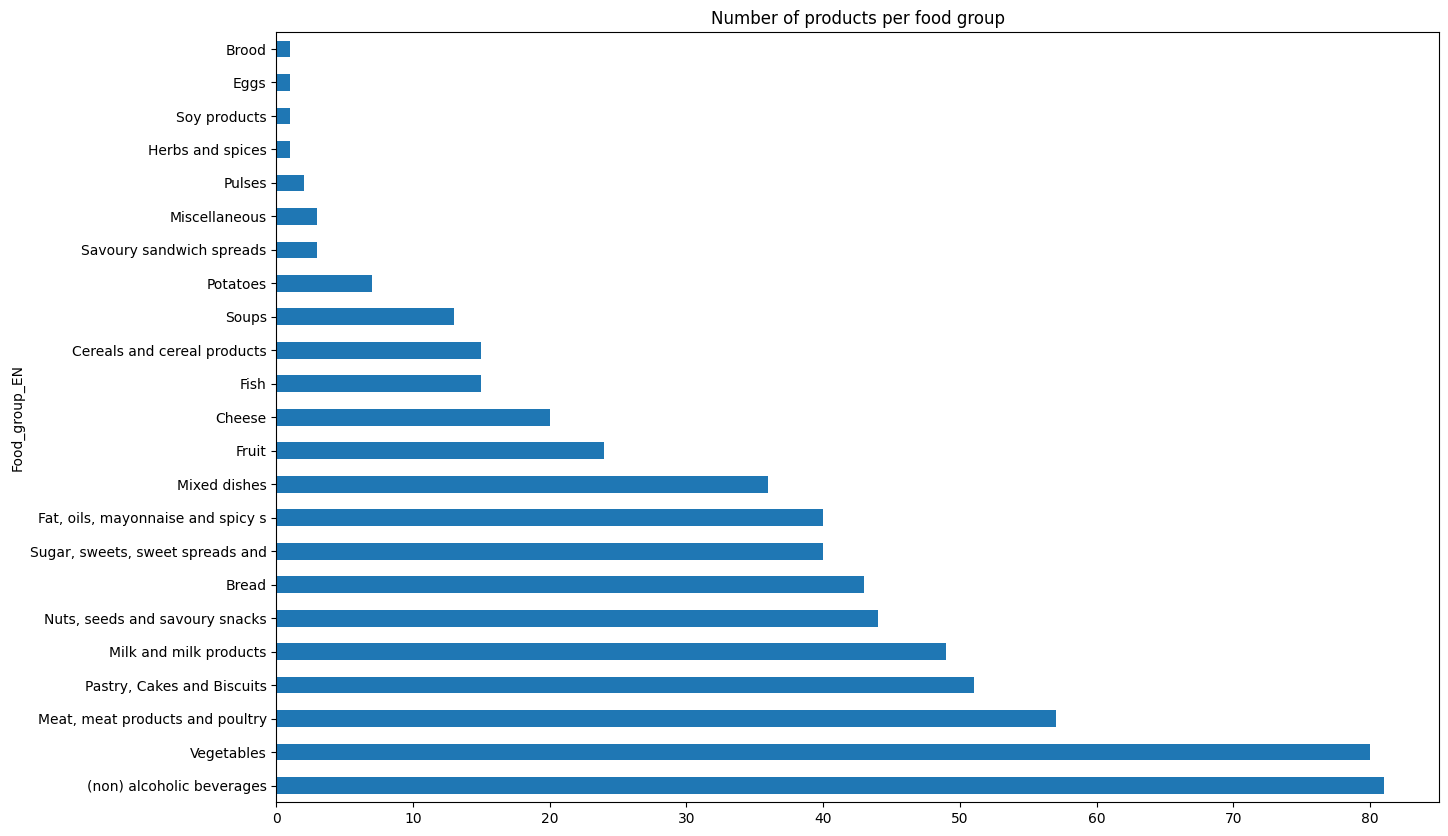

In [16]:
print(f"There are {len(ingredient_df.groupby('Food_group_EN'))} different food groups in the dataset")
ingredient_df.groupby('Food_group_EN').count()['Product_description_EN'].sort_values(ascending=False).plot.barh(figsize = (15, 10))
plt.title('Number of products per food group')
plt.show()

Four groups have only one product. This gives a very big contrast when comparing to a group of almost 80 different products of vegetables and (non) alcoholic beverages.

#### 2.2.3. Taste

In [17]:
ingredient_df.filter(items = value_taste_columns).describe()

,m_sweet,m_sour,m_bitter,m_umami,m_fat,m_salt
count,627.000000,627.000000,627.000000,627.000000,627.000000,627.000000
mean,20.510367,10.969697,4.881978,7.405104,28.068581,15.287081
std,19.488453,14.243009,10.859491,10.820870,24.113948,16.538286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,2.000000,1.000000,1.000000,7.000000,3.000000
50%,11.000000,5.000000,1.000000,2.000000,23.000000,9.000000
75%,35.000000,15.000000,4.000000,11.500000,44.000000,25.000000
max,88.000000,97.000000,74.000000,86.000000,98.000000,94.000000


Each product was rated on a scale of 0 to 100 for each of the tastes. Most products have a high value of only one of the tastes (rarely two).

In [18]:
for taste in value_taste_columns:
    product = ingredient_df.sort_values(taste).tail(1)[['Product_description_EN', taste]]
    print(f"The most {taste[2:]} product was {product['Product_description_EN'].values[0]} with value {int(product[taste].values[0])}.")

The most sweet product was Condensed milk with value 88.
The most sour product was Juice lemon with value 97.
The most bitter product was Onion juice with value 74.
The most umami product was Soy sauce Kikkoman with value 86.
The most fat product was Oil olive with value 98.
The most salt product was Soy sauce Kikkoman with value 94.


### 2.3. Summary

The structure of the original dataset will for sure be useful in our approach, as the ingredients are given in a uniform way, which will allow us to group them into more general groups and simplify the problem.

After the grouping we should be able to use at least part of the taste dataset to enrich the information about the ingredients.

Our main concern is that that taste dataset is relatively small: only 627 products, whereas the original dataset consists of almost 15k - even after simplification, it's likely we'll have missing metadata for some ingredients.

For this reason we might switch to a different dataset or even create our own if we find it necessary.

## 3. Data Preparation

As a part of our project, we need to recategorize the ingredients to their simplest form. We tried two approaches - AI-based and rule-based.
We also discarded the ingredients that could not be recategorized.

### 3.1. Ingredients categorization by GPT-3.5 turbo model

To facilitate AI-based categorization we decided to use OpenAI's GPT-3.5 turbo model using their API.

This solution allowed us to quickly obtained the results of decent quality.

#### 3.1.1. Loading the categories

In [35]:
CATEGORIZED_INGREDIENTS_PATH = "./data/categorized.json"
BAD_CATEGORY = "unknown"

with open(CATEGORIZED_INGREDIENTS_PATH) as f:
    categorized_ingredients: dict = json.load(f)

categorized_ingredients.pop(BAD_CATEGORY, None)
categorized_ingredients = {k.lower(): v for k, v in categorized_ingredients.items() if v != BAD_CATEGORY}

failed = [
    ingredient
    for ingredient in ingredient_counts.keys()
    if ingredient not in categorized_ingredients
]
print(f"Failed to categorize {len(failed)} ingredients")

Failed to categorize 805 ingredients


Due to the way GPT-3.5 turbo model works, some ingredients were not processed by the model - either skipped or processed incorrectly. We decided to discard these ingredients.

In [52]:
failed[:10]

['uice of',
 'wood bethony',
 'lean pork chops',
 'chicken rice soup',
 'escarole',
 'lemo',
 'black cumin',
 'margarine',
 'sage',
 'salt & pepper']

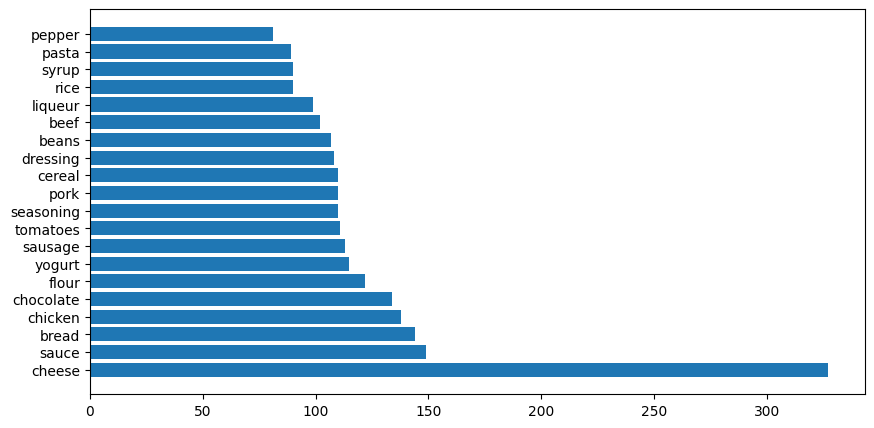

In [40]:
counted_categories = collections.Counter(categorized_ingredients.values())
most_common = counted_categories.most_common(20)

plt.figure(figsize=(10, 5))
plt.barh([category for category, _ in most_common], [count for _, count in most_common])
plt.show()

#### 3.1.2. Loss of data analysis

In [51]:
num_categories = len(counted_categories)
num_ingredients = len(ingredient_counts)

print("Total number of categories:", num_categories)
print("Total number of ingredients:", num_ingredients)
print(f"Reduction in number of ingredients to: {num_categories / num_ingredients * 100:.2f}% of original size")

Total number of categories: 3104
Total number of ingredients: 14917
Reduction in number of ingredients to: 20.81% of original size


In [60]:
recategorized_ingredients = [
    categorized_ingredients[ingredient]
    for ingredient in itertools.chain.from_iterable(ingredients)
    if ingredient in categorized_ingredients
]

len(recategorized_ingredients)
print(f"Retained {len(recategorized_ingredients) / df['n_ingredients'].sum() * 100:.2f}% of ingredients usage")

Retained 98.16% of ingredients usage


#### 3.1.3. Recategorization results

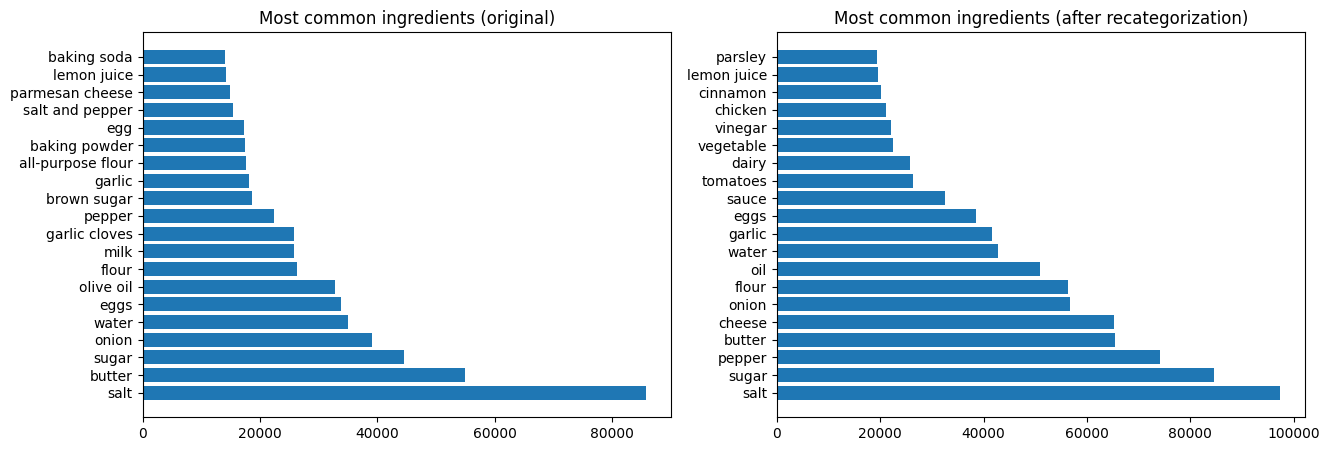

In [66]:
ingredient_recounts = collections.Counter(recategorized_ingredients)
most_common_ingredients_recategorized = ingredient_recounts.most_common(20)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].barh([ingredient for ingredient, _ in most_common_ingredients], [count for _, count in most_common_ingredients])
axs[0].set_title("Most common ingredients (original)")
axs[1].barh([ingredient for ingredient, count in most_common_ingredients_recategorized if count > 1000], [count for ingredient, count in most_common_ingredients_recategorized if count > 1000])
axs[1].set_title("Most common ingredients (after recategorization)")
plt.show()

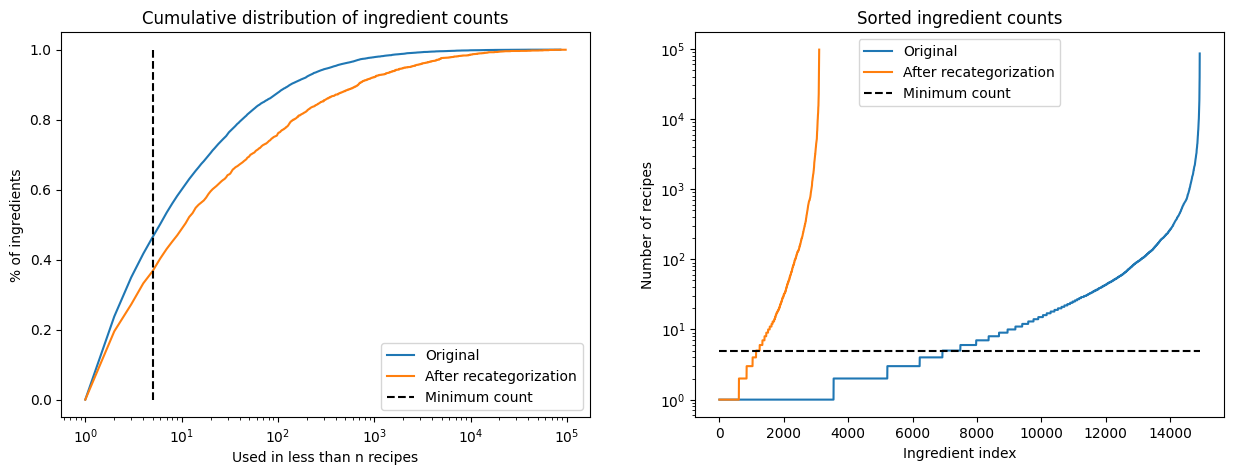

In [111]:
MIN_RECIPIES_COUNT = 5

re_counts_arr = np.array(tuple(ingredient_recounts.values()))
re_ing_x = [i for i in range(1, re_counts_arr.max() + 1)]
re_ing_y = [(re_counts_arr < i).sum() / re_counts_arr.shape[0] for i in re_ing_x]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(ing_x, ing_y, label="Original")
axs[0].plot(re_ing_x, re_ing_y, label="After recategorization")
axs[0].plot([MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], [0, 1], label="Minimum count", linestyle="--", color="black")
axs[0].set_xscale('log')
axs[0].set_title("Cumulative distribution of ingredient counts")
axs[0].set_xlabel("Used in less than n recipes")
axs[0].set_ylabel("% of ingredients")
axs[0].legend()

axs[1].plot(sorted(counts_arr), label="Original")
axs[1].plot(sorted(re_counts_arr), label="After recategorization")
axs[1].plot([0, counts_arr.shape[0]], [MIN_RECIPIES_COUNT, MIN_RECIPIES_COUNT], label="Minimum count", linestyle="--", color="black")
axs[1].set_title("Sorted ingredient counts")
axs[1].set_xlabel("Ingredient index")
axs[1].set_ylabel("Number of recipes")
axs[1].legend()
axs[1].set_yscale('log')

plt.show()

In [107]:
parsed_min_count = [(v, count) for v, count in ingredient_counts.most_common() if count >= MIN_RECIPIES_COUNT]
parsed_min_recount = [(v, count) for v, count in ingredient_recounts.most_common() if count >= MIN_RECIPIES_COUNT]

print(f"Number of ingredients with at least {MIN_RECIPIES_COUNT} recipes:")
print(f"Original: {len(parsed_min_count)}")
print(f"After recategorization: {len(parsed_min_recount)}")
print(f"Reduction: {len(parsed_min_recount) / len(parsed_min_count) * 100:.2f}%")

Number of ingredients with at least 5 recipes:
Original: 7992
After recategorization: 1962
Reduction: 24.55%


In [117]:
len(ingredient_recounts.most_common())

3100

In [113]:
len(ingredient_recounts)

3100

#### 3.1.4. Summary

Recategorization by GPT-3.5 turbo model was a good starting point, but it was not perfect. It managed to reduce the number of ingredients from 15k to 3k overall, and from 8k to 2k valid frequently used enough ones, but this is still a lot of ingredients to work with - much more than the number of entries in the taste dataset.

With this approach it will be necessary to create our own dataset with ingredients and their metadata.